In [ ]:
# Import tensorflow and print current version
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
# Import rest of libraries used in the code. Usually this is done at the beginning of the document but it can be done at any position
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import SGD, Adagrad, Adadelta
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler
import os

In [ ]:
# Hyperparameters:
# They must be carefully select depending on the dataset and model

NB_EPOCH = 30       # Number of training epochs
VALIDATION_SPLIT=0.2 # Size of the validation split taken from the training set. If your dataset has validation split, skip this part.

Cargamos el dataset:

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
PATH_OF_DATA= '/content/gdrive/MyDrive/Curso-Jetson/imagenes'

In [ ]:
import pathlib
#!mkdir -p PATH_OF_DATA
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file(PATH_OF_DATA, origin=dataset_url, untar=True)
#data_dir = pathlib.Path(data_dir)

In [ ]:
!ls '/content/gdrive/MyDrive/Curso-Jetson/imagenes'

dedos


In [ ]:
 #!tar -xvzf '/content/gdrive/MyDrive/Curso-Jetson/imagenes/dedos' -C '/content/gdrive/MyDrive/Curso-Jetson/imagenes'

In [ ]:
!ls '/content/gdrive/MyDrive/Curso-Jetson/imagenes/dedos'

1  10  2  3  4	5  6  7  8  9


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/Curso-Jetson/imagenes/dedos', labels='inferred', subset="training", validation_split=VALIDATION_SPLIT, seed=0)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/Curso-Jetson/imagenes/dedos', labels='inferred', subset="validation", validation_split=VALIDATION_SPLIT, seed=0)

Found 1103 files belonging to 10 classes.
Using 883 files for training.
Found 1103 files belonging to 10 classes.
Using 220 files for validation.


In [ ]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

Vamos a visualizar una de las muestras y la clase a la que pertenece:

4


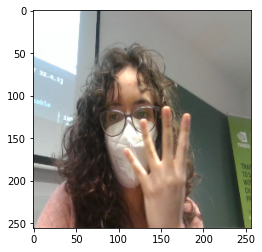

In [ ]:
import matplotlib.pyplot as plt
sample = list(train_ds.as_numpy_iterator())[0]    # Tupla con el batch
image = sample[0]                                 # Batch de imagenes
label = sample[1]                                 # Batch de labels
plt.imshow(np.squeeze(image[0])/255.0)
print(label[0])

In [ ]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)

In [ ]:
# Create a pretrained model.
model = tf.keras.applications.ResNet50(
  include_top=False, weights='imagenet', input_shape=(256,256,3), classes=10)

for l in model.layers:
  l.trainable=False
# Add new classification layer
flat = tf.keras.layers.Flatten()(model.output)
out = tf.keras.layers.Dense(10, activation='softmax')(flat)

model = tf.keras.models.Model(inputs=model.inputs, outputs=out)

model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_____________________________

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=NB_EPOCH, validation_data=val_ds)

Epoch 1/30
28/28 [==============================] - 108s 4s/step - loss: 25.2040 - accuracy: 0.1175 - val_loss: 12.9668 - val_accuracy: 0.2636
Epoch 2/30
28/28 [==============================] - 15s 443ms/step - loss: 9.1605 - accuracy: 0.2632 - val_loss: 2.0356 - val_accuracy: 0.3273
Epoch 3/30
28/28 [==============================] - 15s 441ms/step - loss: 1.9099 - accuracy: 0.4532 - val_loss: 1.4534 - val_accuracy: 0.5818
Epoch 4/30
28/28 [==============================] - 15s 441ms/step - loss: 1.3057 - accuracy: 0.5956 - val_loss: 0.7918 - val_accuracy: 0.7091
Epoch 5/30
28/28 [==============================] - 15s 439ms/step - loss: 0.8515 - accuracy: 0.7140 - val_loss: 0.6178 - val_accuracy: 0.7636
Epoch 6/30
28/28 [==============================] - 15s 439ms/step - loss: 0.6591 - accuracy: 0.7685 - val_loss: 0.6248 - val_accuracy: 0.7455
Epoch 7/30
28/28 [==============================] - 15s 433ms/step - loss: 0.5785 - accuracy: 0.8008 - val_loss: 0.5092 - val_accuracy: 0.8364

In [ ]:
model.evaluate(val_ds)

7/7 [==============================] - 3s 120ms/step - loss: 0.0821 - accuracy: 0.9773


[0.0821240097284317, 0.9772727489471436]

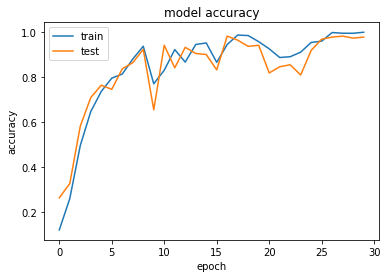

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

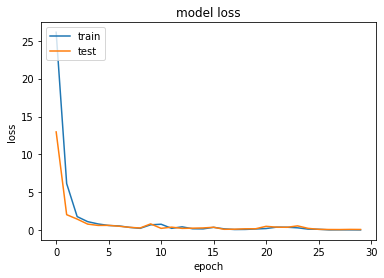

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Save model
OUT_MODEL_PATH= '/content/gdrive/MyDrive/Curso-Jetson/models'
model.save(os.path.join(OUT_MODEL_PATH, 'model-final-finger.hdf5'))
model.save(os.path.join(OUT_MODEL_PATH, 'model-final-finger'))

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Curso-Jetson/models/model-final-finger/assets


In [ ]:
!ls $OUT_MODEL_PATH

model-final-finger	 model-final-pract1
model-final-finger.hdf5  model-final-pract1.hdf5
